In [16]:
import numpy as np
import cupy as cp
import pandas as pd
import time
import matplotlib.pyplot as plt
from itertools import combinations,product
from multiprocessing import Pool
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.datasets import load_digits, fetch_openml
from sklearn.model_selection import GridSearchCV
from qiskit import QuantumCircuit, transpile
from qiskit_aer import Aer
from qiskit.circuit import ParameterVector
from cuquantum import *
import time
import cupy as cp
from cupy.cuda.runtime import getDeviceCount
from mpi4py import MPI

root = 0
comm_mpi = MPI.COMM_WORLD
rank, size = comm_mpi.Get_rank(), comm_mpi.Get_size()
device_id = 0
cp.cuda.Device(device_id).use()
print(f"Using GPU:{device_id}")

mnist = fetch_openml('mnist_784')
X = mnist.data.to_numpy()
Y = mnist.target.to_numpy().astype(int)
class_list = [7,9]
c01 = np.where((Y == class_list[0])|(Y == class_list[1]))
X,Y = X[c01],Y[c01]
MAX=500
data_train, label_train = X[:MAX],Y[:MAX]
X_train, X_val, Y_train, Y_val = train_test_split(data_train, label_train, test_size = 0.2, random_state=255)
print("Train-set shape:", np.shape(X_train), np.shape(Y_train))   ## 800 x 28x 28
print("Test -set shape:", np.shape(X_val), np.shape(Y_val))


Using GPU:0
Train-set shape: (400, 784) (400,)
Test -set shape: (100, 784) (100,)


In [19]:
import cuquantum, sklearn, qiskit, qiskit_algorithms
print(f"Qiskit: {qiskit.__version__}")
print(f"Qiskit ML: {qiskit_algorithms.__version__}")
print(f"cuQuantum: {cuquantum.__version__}")
print(f"skLearn: {sklearn.__version__}")


Qiskit: 1.1.0
Qiskit ML: 0.3.0
cuQuantum: 24.03.0
skLearn: 1.5.0


In [66]:
def data_prepare(nq, sample_train, sample_test, nb1, nb2):
    std_scale = StandardScaler().fit(sample_train)
    data = std_scale.transform(sample_train)
    sample_train = std_scale.transform(sample_train)
    sample_test  = std_scale.transform(sample_test)
    #pca = PCA(n_components=nq, svd_solver="full").fit(data)
    pca = PCA(n_components=nq, svd_solver="auto").fit(data)
    sample_train = pca.transform(sample_train)
    sample_test = pca.transform(sample_test)
    samples = np.append(sample_train, sample_test, axis=0)
    minmax_scale = MinMaxScaler((-1, 1)).fit(samples)
    sample_train = minmax_scale.transform(sample_train)[:nb1]
    sample_test = minmax_scale.transform(sample_test)[:nb2]
    return sample_train, sample_test

def make_bsp(nq):
    param = ParameterVector("p",nq)
    bsp_qc = QuantumCircuit(nq)
    bsp_qc.h(list(range(nq)))         ### n
    for q in range(nq):               ### 2n
        bsp_qc.rz(param.params[q],[q])
        bsp_qc.ry(param.params[q],[q])
    for q in range(nq-1):             ### n-1
        bsp_qc.cx(q, q+1)
    for q in range(nq):               ### n
        bsp_qc.rz(param.params[q],[q])
    return bsp_qc

# ZY0:  q+1
# ZYn:  q+4+6*(n-1)   : n,1,q-1
# ZZn:      q+7+6n    : n,0,q-2
# ZZ(q-1):  q+7+6*(q-2)+2= 7q-3
# YZn: 8q-2+3n        : n,0,q-1
def new_op(nq,op,y_t,x_t, izy,izz,iyz):
    new = op[:]
    for i in range(nq):
        d1, d2 = y_t[i], x_t[i]
        z_g  = np.array([[np.exp(-1j*0.5*d1),0],[0,np.exp( 1j*0.5*d1)]])
        z_gd = np.array([[np.exp( 1j*0.5*d2),0],[0,np.exp(-1j*0.5*d2)]])        
        y_g  = np.array([[np.cos(d1/2),-np.sin(d1/2)],[ np.sin(d1/2),np.cos(d1/2)]])
        y_gd = np.array([[np.cos(d2/2), np.sin(d2/2)],[-np.sin(d2/2),np.cos(d2/2)]])

        n_zy_g = [z_g]
        n_zy_g.append(y_g)
        new[izy[i]:izy[i]+2] = cp.array(n_zy_g)

        n_zz_g = [z_g]
        n_zz_g.append(z_gd)
        new[izz[i]:izz[i]+2] = cp.array(n_zz_g)

        n_zy_g = [y_gd]
        n_zy_g.append(z_gd)
        new[iyz[i]:iyz[i]+2] = cp.array(n_zy_g)
    return new

def kernel_matrix_tnsm(y_t, x_t, opers, indices_list, network, mode='train'):
    kernel_matrix = np.zeros((len(y_t),len(x_t)))
    with network as tn:
        for i, (i1, i2) in enumerate(indices_list):
            tn.reset_operands(*opers[i])
            amp_tn = abs(tn.contract()) ** 2
            kernel_matrix[i1-1][i2-1] = np.round(amp_tn,15)
    if mode == 'train':
        kernel_matrix = kernel_matrix + kernel_matrix.T+np.diag(np.ones((len(x_t))))
    return kernel_matrix
    
def list2kernel(amp, indices_list, y_t, x_t, mode='train'):
    chunk = len(amp[0])
    kernel_matrix = np.zeros((len(y_t),len(x_t)))
    for i, (i1, i2) in enumerate(indices_list):
        kernel_matrix[i1-1][i2-1] = amp[i//chunk][i%chunk]
    if mode == 'train':
        kernel_matrix = kernel_matrix + kernel_matrix.T+np.diag(np.ones((len(x_t))))
    return kernel_matrix
    
def operand_to_amp(opers, indices_list, network):
    amp_tmp = []
    with network as tn:
        for i, (i1, i2) in enumerate(indices_list):
            tn.reset_operands(*opers[i])     
            amp_tn = abs(tn.contract()) ** 2
            amp_tmp.append(amp_tn)
    return amp_tmp

In [23]:
def test_train(ndim, dtrain, genop=True):
    
    indices_list_t = list(combinations(range(1, len(dtrain) + 1), 2))

    ### MPI data decomposition...
    num_data = len(indices_list_t)
    chunk, extra = num_data // size, num_data % size
    data_begin = rank * chunk + min(rank, extra)
    data_end = num_data if rank == size - 1 else (rank + 1) * chunk + min(rank + 1, extra)
    data_index = range(data_begin,data_end)
    indices_list_rank = indices_list_t[data_begin:data_end]
    # print(f"Process {rank} is processing data range: {data_index}.",num_data,len(indices_list_rank))

    ### exp
    t0 = time.time()
    psix=make_bsp(ndim)
    psiy=psix.inverse()
    circuit = psix.assign_parameters(dtrain[0]).compose(psiy.assign_parameters(dtrain[1]))    #### QuantuKernrel
    converter = CircuitToEinsum(circuit, dtype='complex128', backend='cupy')
    a = str(0).zfill(ndim)
    exp, oper = converter.amplitude(a)
    exp_t = round((time.time()-t0),3)

    ### Find optimal contraction path
    t0 = time.time()
    options = NetworkOptions(blocking="auto",device_id=device_id)
    network = Network(exp, *oper,options=options)
    path, info = network.contract_path()
    network.autotune(iterations=20)
    path_t = round((time.time()-t0),3)

    ### Buing operators for each kernel element
    t0 = time.time()
    oper_train = []
    if genop:
        n=ndim
        izy = 6*np.array(range(n)) + n - 2
        izy[0] = n+1
        izz = 6*np.array(range(n)) + n + 7
        izz[n-1] = 7*n-3
        iyz = 3*np.array(range(n)) + 8*n -2        
        for i1, i2 in indices_list_t:
            op = new_op(ndim,oper,dtrain[i1-1],dtrain[i2-1], izy,izz,iyz)
            oper_train.append(op)
    else:
        for i1, i2 in indices_list_t:
            cir = psix.assign_parameters(dtrain[i1-1]).compose(psiy.assign_parameters(dtrain[i2-1]))
            con = CircuitToEinsum(cir, dtype='complex128', backend='cupy')
            exp, op = con.amplitude( a )
            oper_train.append(op)
    oper_t = round((time.time()-t0),3)

    ### Calculte kernels
    t0 = time.time()
    #tnsm_kernel_matrix_train = kernel_matrix_tnsm(dtrain, dtrain, oper_train, indices_list_t, network, mode='train')

    amp_list = operand_to_amp(oper_train, indices_list_rank, network)
    amp_list = cp.array(amp_list)

    ### Reduce
    data = comm_mpi.gather(amp_list, root=0)
    kernel_t = round((time.time()-t0),3)
    if rank == root:
        #print(f"Exp: {exp_t}  Path: {path_t}   Op: {oper_t}   Kernel: {kernel_t} ...")
        print(ndim, len(dtrain), exp_t, path_t, oper_t, kernel_t, f"{len(amp_list)} / {len(data)}")
        return(data)

In [26]:
ndim=10
nb1,nb2=80,1
dtrain, _ = data_prepare(ndim, X_train, X_val, nb1, nb2)
amp = test_train(ndim,dtrain)
## B = test_train(ndim,dtrain, False)   ## slower, but the same with the above

10 80 0.062 1.19 16.038 14.574 3160 / 1
10 80 0.065 2.165 101.69 14.125 3160 / 1


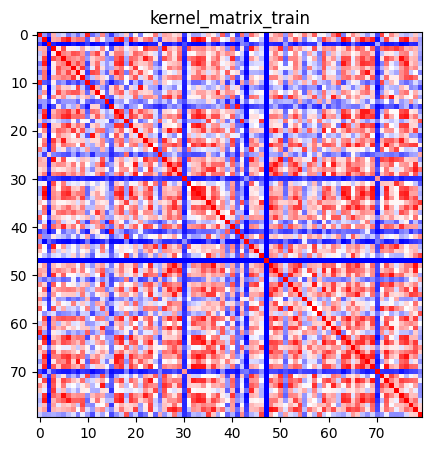

In [90]:
## transfer to CPU for plotting
indices_list = list(combinations(range(1, len(dtrain) + 1), 2))
ker = list2kernel(A, indices_list, dtrain, dtrain,'train')

fig, axs = plt.subplots(1, 1, figsize=(10, 5))
axs.imshow(np.asmatrix(ker), interpolation="nearest", origin="upper", cmap="bwr")
axs.set_title("kernel_matrix_train")
plt.show()